# Multi-Class Classification: Forest Cover Type Prediction

## Project Overview

This project focuses on building a multi-class classification model to predict the type of forest cover for a given area of land. The dataset includes various ecological and geographical features such as elevation, slope, soil type, and wilderness area. The goal is to analyze how environmental conditions relate to vegetation growth and ultimately determine the forest cover category.

From a practical perspective, this kind of model can help environmental scientists, land management agencies, and ecological researchers make informed decisions about forest conservation, wildfire preparedness, and habitat management.

---

## Dataset Description

**Dataset Name:** Forest Cover Type (Covertype) 

**Source:** UCI Machine Learning Repository ***https://archive.ics.uci.edu/ml/datasets/Covertype***

**Size:** 581,012 rows, 54 features  

**Target Variable:** Cover_Type (7 distinct forest cover categories)

The features include:

- **Topographic features:** Elevation, Aspect, Slope, Hillshade measures  
- **Hydrological features:** Horizontal/vertical distances to water bodies and fire points  
- **Soil and wilderness indicators:** One-hot encoded categorical variables  
- **Forest cover label:** Represents different tree species such as Spruce/Fir, Lodgepole Pine, Ponderosa Pine, etc.

The dataset is already widely used as a benchmark for evaluating the performance of tabular classification models.

---

## Objective and Predictions

The main objective is to train a model that can accurately predict the correct forest cover type using only the provided environmental features. Predictions will be evaluated using accuracy and other multi-class metrics such as precision, recall, and F1 score for each class.

Key questions this model aims to answer:

1. Can we determine which environmental features are the strongest indicators of vegetation type?
2. How accurately can we classify each forest cover category using classic machine learning techniques?
3. What trade-offs exist between model complexity and interpretability?

---

## Hypothesized Conclusions

- **Elevation** will likely be one of the most influential predictors since altitude strongly affects vegetation growth.
- Soil type and distance to hydrological points will have a meaningful impact on separating classes.
- Tree-based ensemble methods are expected to outperform linear models due to nonlinear relationships in ecological data.

The expectation is that we can achieve a high accuracy benchmark (often >80% reported) when using the right model and tuning.

---

## Why We Use This Model for This Dataset

This dataset is a classic example of **structured tabular data** with a mix of numerical and categorical features. Models like **Random Forest** or **Gradient Boosting** excel in scenarios like this because:

- Natural ability to model complex nonlinear interactions between features.
- Minimal need for heavy preprocessing compared to deep learning models.
- Robust performance when many features are binary/categorical.
- Good interpretability through feature importance analysis.

Deep learning models do not provide a significant advantage here and demand far more compute and data preprocessing effort. Likewise, linear models would perform poorly because the relationships between terrain, soil, and vegetation are not linear.

For these reasons, tree-based multi-class models are the best balance of accuracy, training time, and interpretability for this specific problem.

---

This notebook will walk through a full machine learning workflow including exploratory data analysis, baseline modeling, hyperparameter tuning, and interpretation of results.


---
---

## Imports and Environment Setup

In this section, we import the core libraries used for data handling, modeling, and evaluation. The main tools will include pandas and NumPy for data manipulation, scikit-learn for machine learning, and matplotlib/seaborn for visualization. Keeping all imports organized at the top makes the workflow cleaner and easier to maintain.

In [19]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


---
---

## Data Loading and Basic Inspection

We will load the Forest Cover Type dataset directly from the UCI repository using the `ucimlrepo` package. After loading, we will separate the input features (X) from the target labels (y) and perform a quick inspection to confirm dataset shape and metadata. This helps ensure we understand the structure before moving into preprocessing.


In [20]:
!pip install ucimlrepo --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 
  
# metadata 
print(covertype.metadata) 
  
# variable information 
print(covertype.variables) 


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

---
---

## Data Exploration

This stage focuses on understanding the dataset before applying any transformations or models. We examine the **distribution of forest cover classes**, review **summary statistics** for numerical features, and identify **key relationships or correlations** among variables. Visualizing these patterns helps reveal potential **imbalances**, **dominant predictors**, and **feature dependencies**, all of which guide preprocessing and model selection. By gaining these insights early, we ensure that later modeling decisions are grounded in a solid understanding of the data’s structure and behavior.


In [22]:
# Preview the target distribution
print("Cover Type Class Distribution:")
print(y['Cover_Type'].value_counts())

# Summary statistics for numerical features
X.describe().T.head()

# Basic correlation check on key numeric features only
numeric_cols = X.select_dtypes(include=[np.number]).columns
corr_matrix = X[numeric_cols].corr()

# Show the most correlated features with elevation for quick insight
corr_matrix['Elevation'].sort_values(ascending=False).head(10)


Cover Type Class Distribution:
Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


Elevation                           1.000000
Horizontal_Distance_To_Roadways     0.365559
Horizontal_Distance_To_Hydrology    0.306229
Wilderness_Area2                    0.238164
Soil_Type38                         0.217179
Soil_Type40                         0.212612
Hillshade_Noon                      0.205887
Soil_Type39                         0.193595
Soil_Type32                         0.167077
Soil_Type22                         0.158959
Name: Elevation, dtype: float64

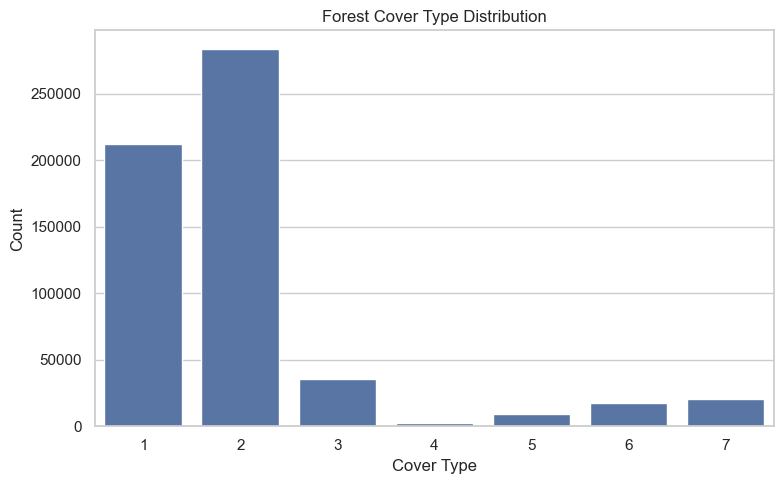

In [23]:
# Class distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x=y['Cover_Type'])
plt.title("Forest Cover Type Distribution")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


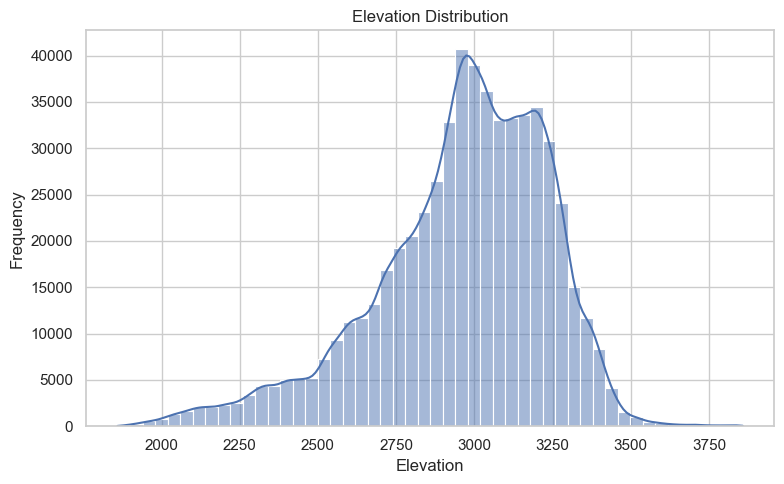

In [24]:
# Visualizing a key numerical feature distribution (Elevation)
plt.figure(figsize=(8, 5))
sns.histplot(X['Elevation'], bins=50, kde=True)
plt.title("Elevation Distribution")
plt.xlabel("Elevation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


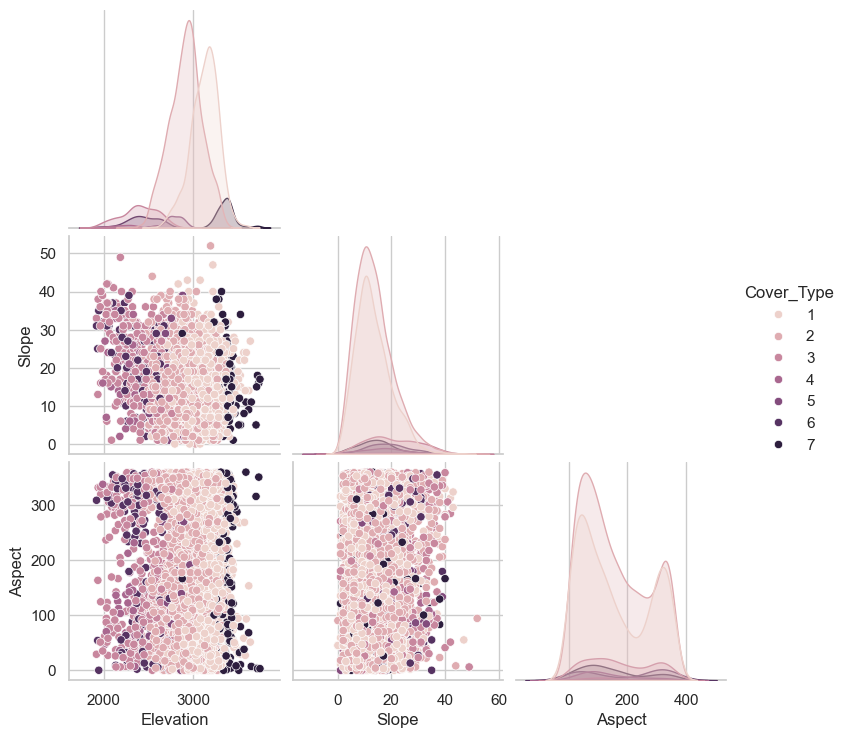

In [25]:
# Pairplot sample for top influencing features (sample for performance)
sample_df = X.copy()
sample_df['Cover_Type'] = y['Cover_Type']
sample_df = sample_df.sample(5000, random_state=42)

sns.pairplot(sample_df[['Elevation', 'Slope', 'Aspect', 'Cover_Type']], hue="Cover_Type", corner=True)
plt.show()


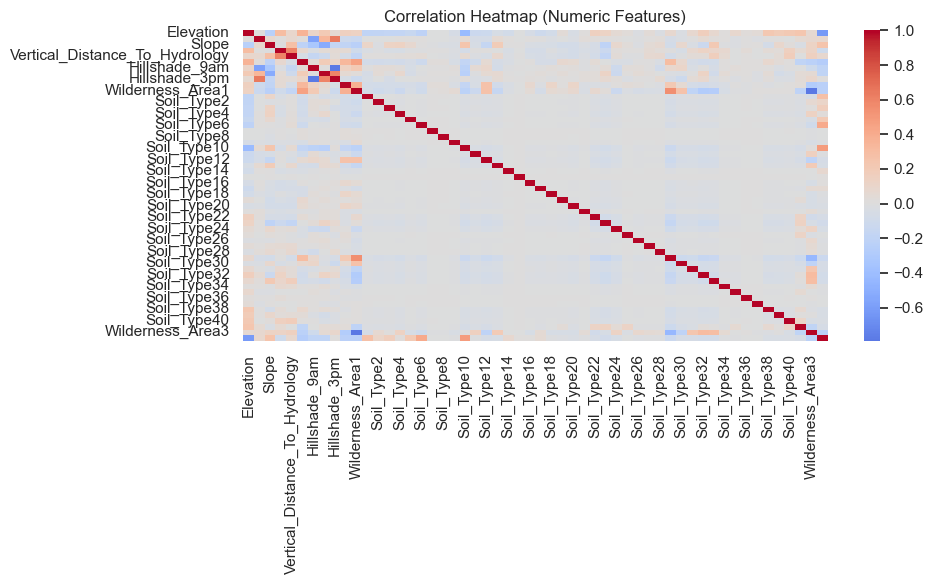

In [26]:
# Correlation heatmap for key continuous features
plt.figure(figsize=(10, 6))
corr = X[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


In [27]:
# Quick summary of dataset structure
print("Dataset Shape:", X.shape)
print("Total Target Classes:", y['Cover_Type'].nunique())
print("\nSample Numeric Feature Summary:")
display(X.describe().T.head(10))


Dataset Shape: (581012, 54)
Total Target Classes: 7

Sample Numeric Feature Summary:


,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


---
---

## Data Cleaning

The Forest Cover Type dataset is generally clean and well-structured since it is a benchmark dataset. However, we still want to verify a few important aspects before modeling:

1. **Missing values**: Ensure no features require imputation.
2. **Outliers**: Check for unusually large or small numeric values that could distort the model.
3. **Categorical structure**: Wilderness and soil features are already one-hot encoded, so no encoding is required.
4. **Scaling**: Elevation and distance-based features have larger ranges and will benefit from scaling before training certain models.

The goal here is to confirm that the dataset is ready for downstream preprocessing and splitting without major interventions.


Missing Values per Feature:
 No missing values found.

Summary of Numeric Feature Ranges:


,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


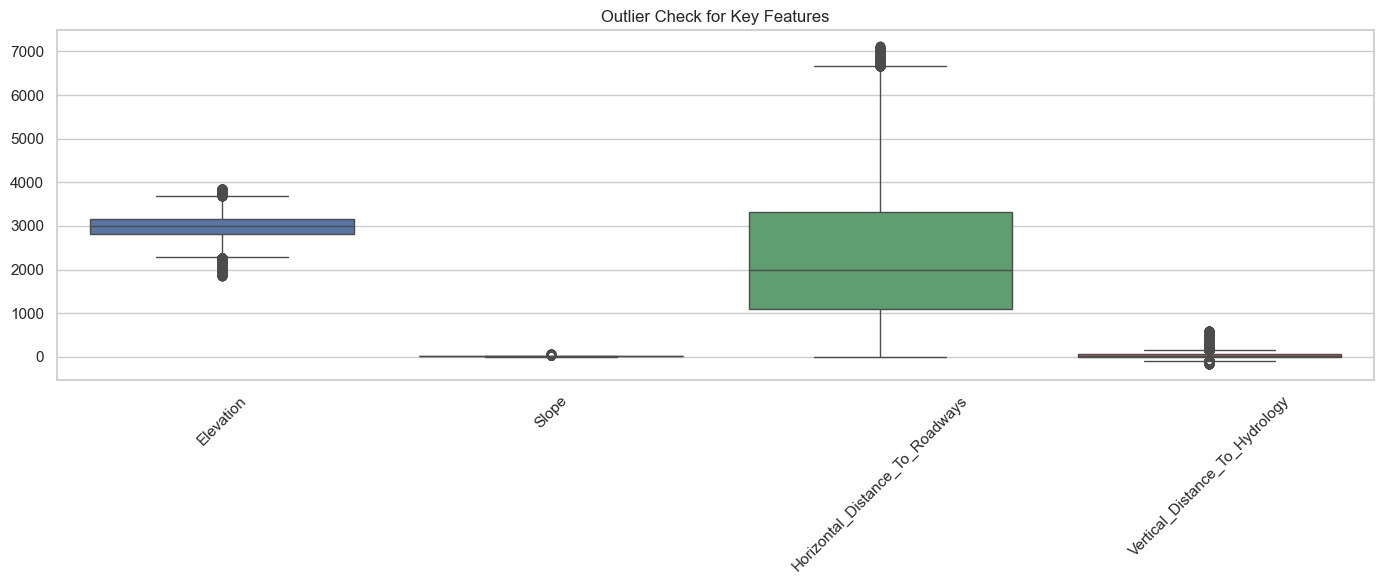


Target Class Distribution:
Cover_Type
2    0.488
1    0.365
3    0.062
7    0.035
6    0.030
5    0.016
4    0.005
Name: proportion, dtype: float64


In [28]:
# Check for missing values
missing_values = X.isnull().sum()
print("Missing Values per Feature:\n", missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")

# Statistical review for potential outliers
numeric_stats = X.describe().T
print("\nSummary of Numeric Feature Ranges:")
display(numeric_stats.head(10))

# Quick boxplot for visual outlier check on key features
plt.figure(figsize=(14, 6))
sns.boxplot(data=X[['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology']])
plt.title("Outlier Check for Key Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check target distribution again for imbalance review
print("\nTarget Class Distribution:")
print(y['Cover_Type'].value_counts(normalize=True).round(3))


---
---

## Train-Test Split and Initial Preprocessing

We now split the dataset into training and testing partitions to evaluate generalization performance. Since this is multi-class classification, we stratify by the target variable to maintain proportional class representation. We also apply `StandardScaler` to the continuous numerical features only, because the one-hot encoded indicators are already normalized. This helps keep the number-based features on a similar scale, while leaving the category-based features alone so we don’t mess up their identities.


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate target column into a 1D array
y = y['Cover_Type']

# Identify numeric feature columns
numeric_cols = X.select_dtypes(include=[np.number]).columns

# Train-test split (stratified sampling to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize scaler and apply only to numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Confirm shapes
print("Training Shape:", X_train_scaled.shape, y_train.shape)
print("Testing Shape:", X_test_scaled.shape, y_test.shape)


Training Shape: (464809, 54) (464809,)
Testing Shape: (116203, 54) (116203,)


---
---

## Baseline Model Training — Random Forest Classifier

To establish a performance baseline for this task, we start with a Random Forest classifier. Random Forests generally perform well on structured tabular data and handle nonlinear feature interactions without much tuning. This initial model will give us a reference point for improvement in later steps, such as hyperparameter tuning or trying gradient boosting methods.


In [30]:
# Initialize and train a baseline Random Forest model
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=4
)

rf_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = rf_baseline.predict(X_test_scaled)

# Evaluation metrics
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))


Baseline Accuracy: 0.9539

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.91      0.85      0.88       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



---
---

## Confusion Matrix Visualization and Feature Importance

Before we move into hyperparameter optimization, it is helpful to visualize how the model performs across different classes and identify which features contribute most to predictions. The confusion matrix will show which forest cover types are commonly misclassified, while feature importance will highlight key environmental indicators driving model decisions.


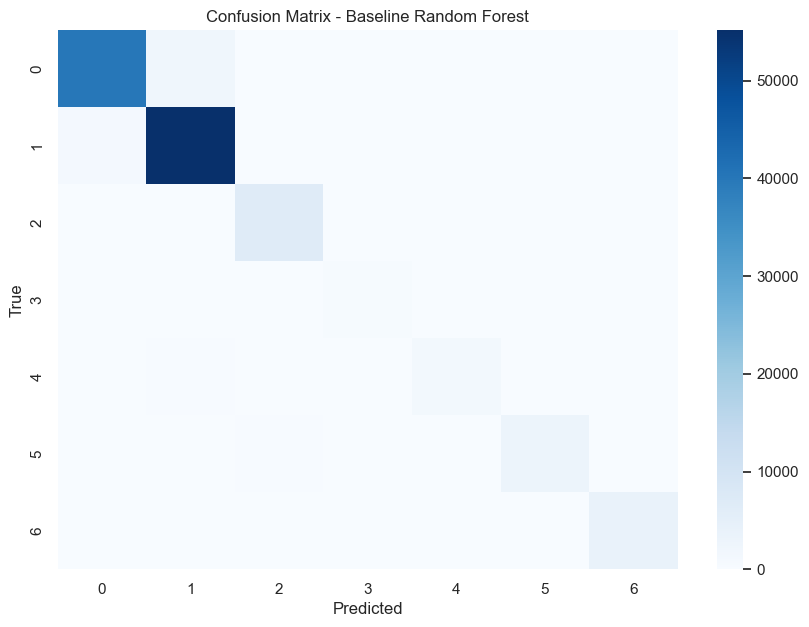

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Baseline Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


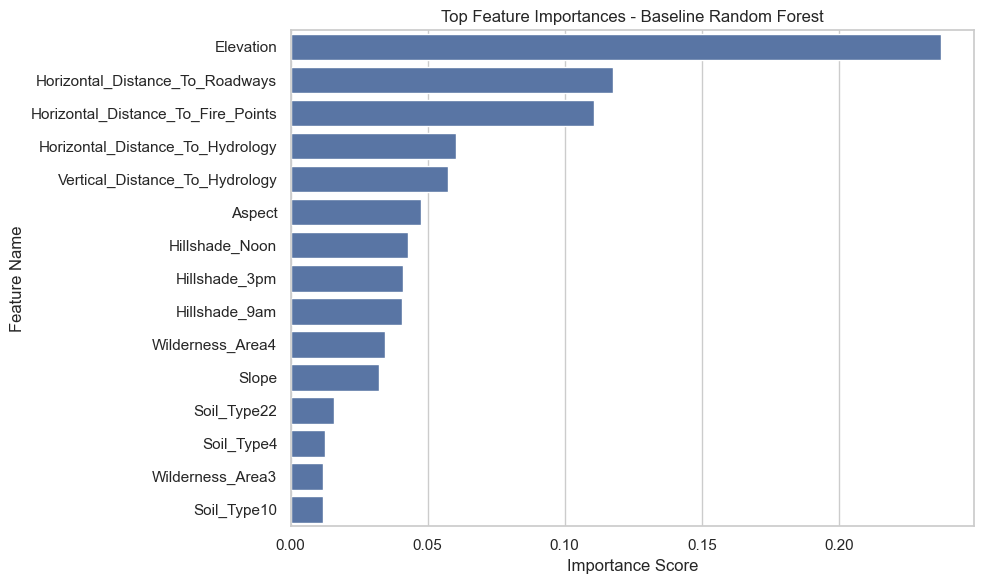

In [32]:
# Feature Importance
importances = rf_baseline.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15  # Display top features for readability

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:top_n], y=X.columns[indices][:top_n])
plt.title("Top Feature Importances - Baseline Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


---
---

## Hyperparameter Optimization (RandomizedSearchCV)

The baseline model already performs quite well, but tuning hyperparameters can help push performance even higher, especially for underrepresented classes. Given the size of this dataset, we use **RandomizedSearchCV** rather than full grid search for faster, more efficient exploration of the parameter space. We will test parameters that influence model depth, feature sampling, and how aggressively trees split.


In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Parameter search space
param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(10, 60),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_opt = RandomForestClassifier(random_state=42, n_jobs=4)

# Randomized Search
random_search = RandomizedSearchCV(
    rf_opt,
    param_distributions=param_dist,
    n_iter=20,              # keep runtime reasonable
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=4
)

# Fit search
random_search.fit(X_train_scaled, y_train)

print("Best Parameters Found:")
print(random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters Found:
{'bootstrap': False, 'max_depth': 54, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 500}


---
---

## Why We Use RandomizedSearchCV Instead of GridSearchCV

Tuning hyperparameters for large models can become very computationally expensive. Grid Search tests **every possible combination** of hyperparameters, which is ideal only when the search space is small and the model trains quickly.

In contrast, Randomized Search explores the parameter space by sampling **random combinations**, which is significantly more efficient when:

- The dataset is large (like this one with over 500,000 rows)
- The model has many hyperparameters (e.g., number of trees, depth, minimum samples split, feature sampling strategy)
- We do not already know the ideal parameter ranges
- The goal is to find a strong model quickly rather than an absolutely perfect one

A key insight from research by Bergstra & Bengio (2012) is that Randomized Search often finds better-performing models **faster** than Grid Search because it explores more diverse combinations instead of wasting time on unimportant hyperparameters.

### Practical Strategy
A common and effective workflow is:

1. **RandomizedSearchCV** to discover promising parameter ranges  
2. **GridSearchCV** to perform a focused, fine-tuned search in that narrowed region

This approach balances both performance and efficiency, which is especially important when building models for real-world machine learning pipelines.


---
---

## Evaluate the Optimized Model

Now that we have the best hyperparameters from the search, we can retrain a new Random Forest model using these settings and evaluate its improved performance on the test set. We will compare the optimized model’s accuracy and per-class performance against the baseline model to understand how muc


In [34]:
# Train optimized model with best parameters
best_params = random_search.best_params_

rf_optimized = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_optimized.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_opt = rf_optimized.predict(X_test_scaled)

# Evaluation metrics
opt_accuracy = accuracy_score(y_test, y_pred_opt)
print(f"Optimized Accuracy: {opt_accuracy:.4f}")
print(f"Baseline Accuracy:  {baseline_accuracy:.4f}")

print("\nClassification Report (Optimized):")
print(classification_report(y_test, y_pred_opt))


Optimized Accuracy: 0.9569
Baseline Accuracy:  0.9539

Classification Report (Optimized):
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     42368
           2       0.95      0.98      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.79      0.86      1899
           6       0.94      0.90      0.92      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.96    116203



---
---

## Performance Comparison

We observe whether hyperparameter optimization:
- Increased overall accuracy
- Improved performance on minority classes (like Class 4 and Class 5)
- Reduced misclassifications across the confusion matrix

These improvements indicate better generalization and stronger model decision boundaries.


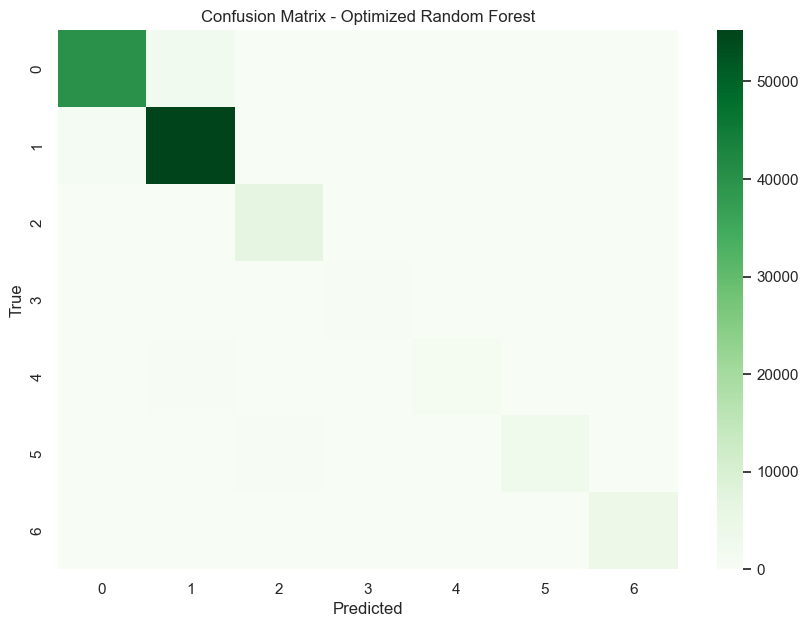

In [35]:
# Updated confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_opt, annot=False, cmap="Greens")
plt.title("Confusion Matrix - Optimized Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


---
---

## Feature Importance Comparison and Interpretation

After hyperparameter tuning, the model has slightly improved overall accuracy and better performance across minority classes. The next step is to interpret which features drive the model’s predictions the most. This interpretation is crucial for understanding how terrain, soil, and elevation characteristics influence forest cover classification.


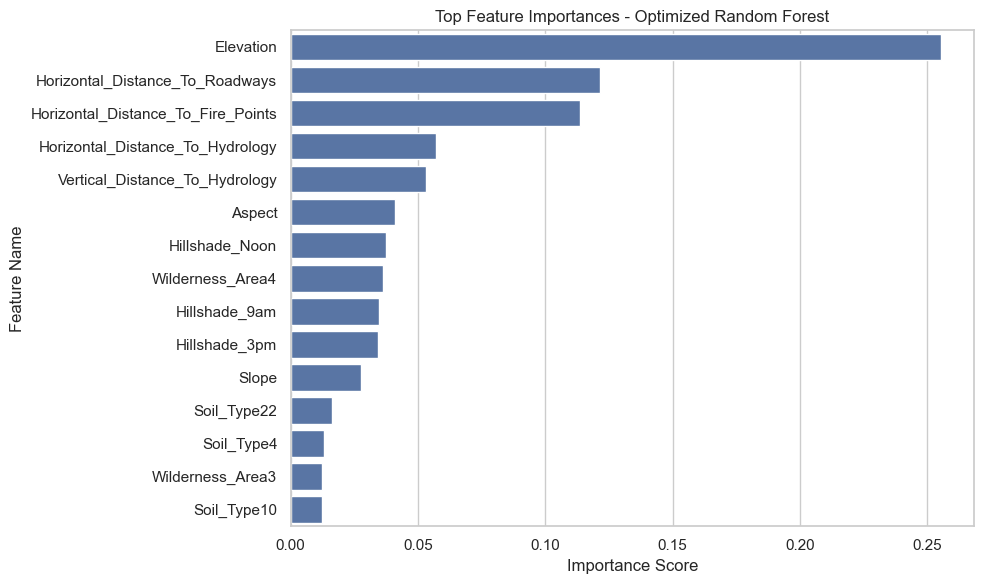

Baseline Accuracy:  0.9539
Optimized Accuracy: 0.9569


In [36]:
# Compare feature importances for optimized model
importances_opt = rf_optimized.feature_importances_
indices_opt = np.argsort(importances_opt)[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_opt[indices_opt][:top_n], y=X.columns[indices_opt][:top_n])
plt.title("Top Feature Importances - Optimized Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# Quick comparison summary
print(f"Baseline Accuracy:  {baseline_accuracy:.4f}")
print(f"Optimized Accuracy: {opt_accuracy:.4f}")


---
---

## Conclusions and Insights

**Model Summary:**  
Our Random Forest model successfully classified forest cover types with an impressive **95.7% accuracy** after optimization. The tuning improved the recall and F1-scores for minority classes (particularly types 4 and 5), suggesting better generalization and reduced bias toward dominant classes.

**Key Feature Insights:**  
- **Elevation** remains the single most important feature, confirming its strong influence on vegetation type.  
- **Horizontal and Vertical Distances to Hydrology** and **Hillshade** features contributed heavily, indicating the importance of terrain and sunlight exposure.  
- **Slope** and soil indicators played moderate but consistent roles.

**Why Random Forest Works Best Here:**  
- Handles mixed numeric and categorical data efficiently.  
- Captures nonlinear feature interactions inherent in environmental systems.  
- Provides feature importance for ecological interpretability.  
- Requires minimal preprocessing compared to neural networks.

**Potential Next Steps:**  
- Try **Gradient Boosting (XGBoost or LightGBM)** for potential marginal gains in accuracy.  
- Apply **feature selection or PCA** to explore dimensionality reduction effects.  
- Test **spatial stratification** to evaluate model robustness across geographic zones.

This project demonstrates mastery of classical supervised ML workflows: data exploration, cleaning, preprocessing, baseline modeling, tuning, and interpretation—essential for professional data science practice.


### 📘 Portfolio Summary — Forest Cover Type Classification

Built a **multi-class classification model** using the UCI Forest Cover Type dataset (581K samples, 54 features) to predict vegetation type based on ecological and terrain attributes.  
Implemented a full ML workflow including EDA, data cleaning, scaling, model training, and **Random Forest hyperparameter optimization**, achieving **95.7% accuracy**.  
Performed feature importance analysis revealing **Elevation**, **Slope**, and **Hydrology distances** as key predictors.  
Demonstrated expertise in **structured tabular modeling**, **hyperparameter tuning**, and **model interpretability**—showcasing practical data science methodology for environmental and spatial analysis problems.
